# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image
into one of two classes: "cat" or "dog". The code for the neural networks
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1vF13-fh5Jsp-6RYfv0xEG2NEFCtNibxt?usp=sharing

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories.
We have included code that automatically downloads the dataset the
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=1) # One image per batch

100%|██████████| 170498071/170498071 [00:04<00:00, 40789656.01it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

NameError: ignored

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes?
What about validation examples?
What about test examples?

In [ ]:
print("Number of training examples: ",len(train_loader))
print("Number of validation examples: ",len(val_loader))
print("Number of test examples: ",len(test_loader))

Number of training examples:  8000
Number of validation examples:  2000
Number of test examples:  2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the
performance of our models using the training set loss/error instead of the validation
set loss/error?

In [ ]:
#There is potential for overfitting or underfitting and using a validation set
#allows us to see the performance of the model in training.
#Since the validation data is not used for training the model,
#it introduces new data for more accurate and unbiased assessment of the model's performance.

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values.

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
small_parameters = 0
large_parameters = 0

for param in small_net.parameters():
    for item in param:
        small_parameters += torch.numel(item)

print("The number of parameters in small_net is: ",small_parameters)

for param in large_net.parameters():
    for item in param:
        large_parameters += torch.numel(item)

print("The number of parameters in small_net is: ",large_parameters)

The number of parameters in small_net is:  386
The number of parameters in small_net is:  9705


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on.

What are the default values of the parameters `batch_size`, `learning_rate`,
and `num_epochs`?

In [ ]:
#The default values of the parameters as stated in the definition of the function which are:
#batch_size=64, learning_rate=0.01, num_epochs=30

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [ ]:
train_net(small_net,num_epochs=5)
#A file for each epoch with accuracy statistics (a total of 5 files ranging for epoch0 to epoch4)
#[naming convention: model_small_bs64_lr0.01_epochX; X changes with the current epoch]
#There will each be a separate file for the training data error, training data loss, validation error, and validation loss,
#which they contain the error and loss values for training and validation data set after each epoch
#[naming convention: model_small_bs64_lr0.01_epoch4_train_err_csv; model_small_bs64_lr0.01_epoch4_train_loss_csv; For validation data "train" is switched with "val" ]
#Therefore, overall a total of 9 files are produced by training small_net using train_net for 5 epochs.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.416875, Train loss: 0.669871614933014 |Validation err: 0.368, Validation loss: 0.6514487471431494
Epoch 2: Train err: 0.354, Train loss: 0.6321520733833313 |Validation err: 0.363, Validation loss: 0.6434976030141115
Epoch 3: Train err: 0.333875, Train loss: 0.6139532294273377 |Validation err: 0.329, Validation loss: 0.6157480981200933
Epoch 4: Train err: 0.324125, Train loss: 0.5996069326400757 |Validation err: 0.3465, Validation loss: 0.6203590370714664
Epoch 5: Train err: 0.31325, Train loss: 0.5931052057743073 |Validation err: 0.3275, Validation loss: 0.6169438250362873
Finished Training
Total time elapsed: 23.10 seconds


### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights)
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train_net(small_net)

train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.3055, Train loss: 0.5858488802909851 |Validation err: 0.3295, Validation loss: 0.6148218754678965
Epoch 2: Train err: 0.3015, Train loss: 0.5823079354763031 |Validation err: 0.346, Validation loss: 0.6325256358832121
Epoch 3: Train err: 0.300375, Train loss: 0.5783811230659485 |Validation err: 0.3205, Validation loss: 0.6066121514886618
Epoch 4: Train err: 0.299, Train loss: 0.5736070265769958 |Validation err: 0.325, Validation loss: 0.605798501521349
Epoch 5: Train err: 0.293, Train loss: 0.5718846187591553 |Validation err: 0.3165, Validation loss: 0.6055945577099919
Epoch 6: Train err: 0.2905, Train loss: 0.5667175335884094 |Validation err: 0.3085, Validation loss: 0.6030273409560323
Epoch 7: Train err: 0.290375, Train loss: 0.5655720829963684 |Validation err: 0.3115, Validation loss: 0.5964282276108861
Epoch 8: Train err: 0.29025, Train loss: 0.5622684617042542 |Validation err: 0.3135, 

In [ ]:

#Time elpased for training small_net is approximately 142.86 seconds.
#"Time elpased for training large_net is approximately 166.62 seconds.

#As shown training large_net took longer since it is more complex (contains many more parameters to train)
#compared to small_net (small_net has only 386 parameters while large_net has 9705 parameters.)

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

In [ ]:
model_path1 = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
model_path2 = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
print("The plots for small_net training:")
plot_training_curve(model_path1)
print("The plots for large_net training:")
plot_training_curve(model_path2)

The plots for small_net training:


FileNotFoundError: ignored

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

In [ ]:
#The curves for small_net are both improving overall
#(the error and loss are all decreasing based on the two graphs) as the number of epoch increases.
#However, they are at around a constant distance apart and are not overlapping on each other as a good model should.
#Therefore, it is possible that the training data is not very representative of the problem,
#leading to the model not learning sufficient information or has significantly less examples compared to the validation data.

#The curves for large_net both started off as close to each other/nearly overlapping (epoch<10).
#Both error and loss are decreasing over this part of the training, showing improvement in the model's performance.
#However, after epoch = 10, the validation curves starts to diverge
#while the training curves continued decreasing as number of epoch increases.
#In the plot of loss, the validation curve is even significant increasing near the end.
#Based on these observation, we can identify that the training of large_net is overfittig.
#This is because as the training error decreases while the validation error increases
#when number of epoch increase past 10,
#which is caused by the the model being too specifically trained to fit the training data
#that does not cover sufficient examples for the classification of dogs and cats.

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360013961792 |Validation err: 0.467, Validation loss: 0.6924686580896378
Epoch 2: Train err: 0.448625, Train loss: 0.6922589712142945 |Validation err: 0.4305, Validation loss: 0.691649341955781
Epoch 3: Train err: 0.43575, Train loss: 0.6916067280769348 |Validation err: 0.4285, Validation loss: 0.690854424610734
Epoch 4: Train err: 0.43, Train loss: 0.690861343383789 |Validation err: 0.424, Validation loss: 0.6896595880389214
Epoch 5: Train err: 0.434125, Train loss: 0.6899195008277893 |Validation err: 0.4195, Validation loss: 0.6886935643851757
Epoch 6: Train err: 0.43575, Train loss: 0.6887411961555481 |Validation err: 0.4195, Validation loss: 0.6867824867367744
Epoch 7: Train err: 0.437125, Train loss: 0.6873774147033691 |Validation err: 0.4185, Validation loss: 0.6851982977241278
Epoch 8: Train err: 0.4375, Train loss: 0.6859278454780579 |Validation err: 0.412,

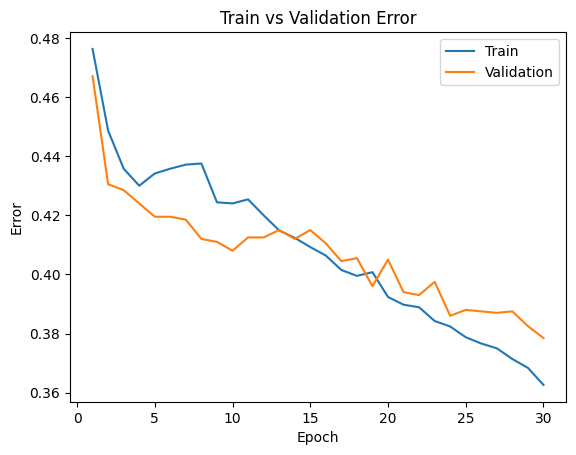

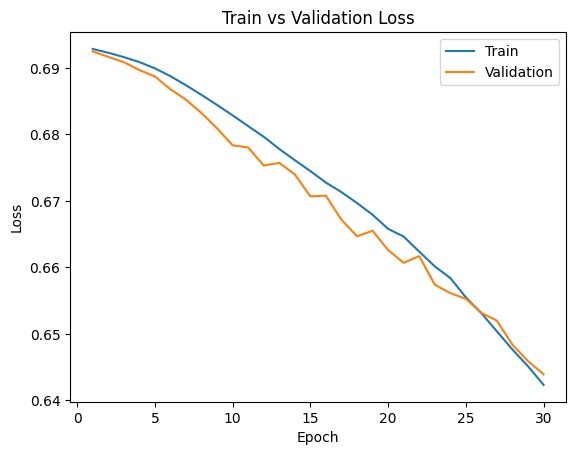

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net,learning_rate=0.001)
model_path3 = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path3)

#The model took longer to train (less efficient in terms of time) compared to Part2
#when we were using learning rate of 0.01 instead of 0.001.
#This indicates the lowering the learning rate slows down the training
#as the steps you are takng are shorter
#The training curves matched well with the validation curves in both graphs
#compared to the previous graphs for training large_net with learning rate of 0.01.
#At the same time, there is a more significant decrease in error and loss
#as the number of epoch increases, indicating a good performance of the model without overfitting.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.67437779712677 |Validation err: 0.3595, Validation loss: 0.6350857093930244
Epoch 2: Train err: 0.36075, Train loss: 0.6411805458068848 |Validation err: 0.3535, Validation loss: 0.6361209936439991
Epoch 3: Train err: 0.365125, Train loss: 0.6321813461780548 |Validation err: 0.3385, Validation loss: 0.6056603882461786
Epoch 4: Train err: 0.352625, Train loss: 0.6233456182479858 |Validation err: 0.3575, Validation loss: 0.6362800188362598
Epoch 5: Train err: 0.34075, Train loss: 0.6108013873100281 |Validation err: 0.3305, Validation loss: 0.6064918786287308
Epoch 6: Train err: 0.323375, Train loss: 0.5921835997104645 |Validation err: 0.317, Validation loss: 0.5967769594863057
Epoch 7: Train err: 0.3145, Train loss: 0.5817317583560944 |Validation err: 0.3365, Validation loss: 0.6204487886279821
Epoch 8: Train err: 0.29825, Train loss: 0.5660300073623658 |Validation err: 0.

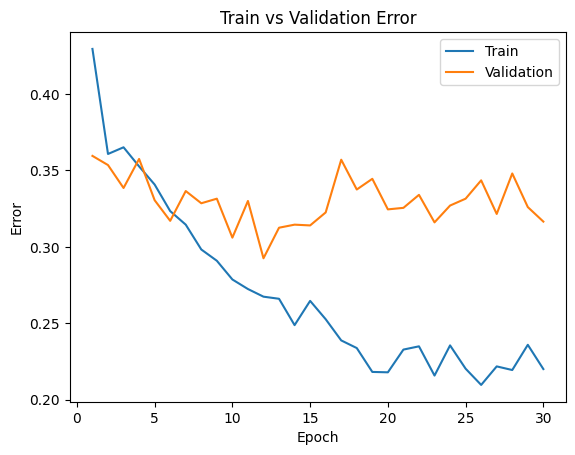

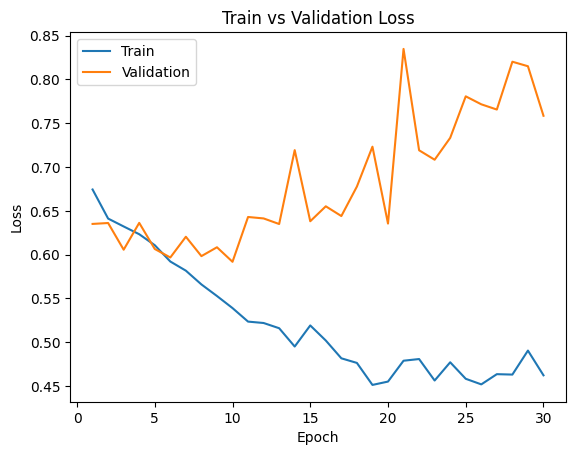

In [ ]:
large_net = LargeNet()
train_net(large_net,learning_rate=0.1)
model_path4 = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(model_path4)

#The model took a similar amount to train as using a learning rate of 0.001,
#which is also slower than using a learning rate of 0.01.
#The training curve and validation curve did not match well when plotted in terms of error and loss.
#Both was closer when the number of epoch is smaller than 5,
#and drastically diverged after such, with the validation data curve increasing in terms of error and loss
#while training data curve continued to decrease.
#This shows that by increasing the learning rate in this case,
#the model continued to overfit more to the training data.

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104019999504 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500590741634 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449940383434 |Validation err: 0.424, Validation loss: 0.6897870451211929
Epoch 5: Train err: 0.434, Train loss: 0.6896935552358627 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.688353206962347 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871677339077 |Validation err: 0.426, Validation loss: 0.6836968809366226
Epoch 8: Train err: 0.43525, Train loss: 0.6849770769476891 |Validation err: 0.4115, Va

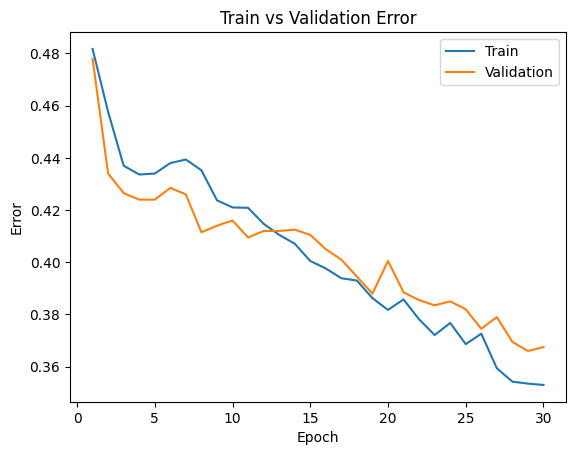

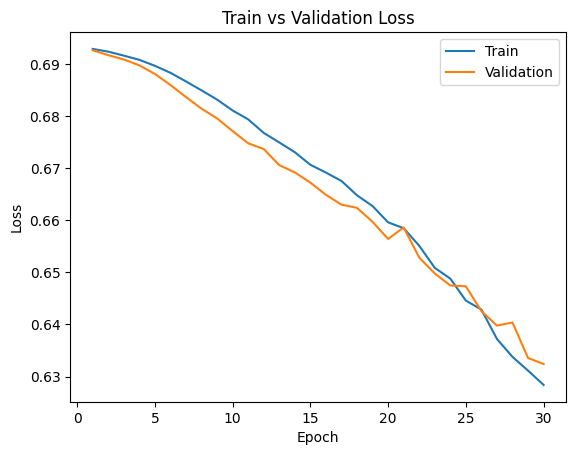

In [ ]:
large_net = LargeNet()
train_net(large_net,batch_size=512)
model_path5 = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_path5)
#The model took less time to train as the ones above when the learning rate is modified
#but longer than when using all default parameters.
#Overall the model showed good performance with the increase in the batch size
#as both the error and loss are decreasing as the number of epoch increases,
#with the validation and training curve closely overlaying.

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774994022846222 |Validation err: 0.382, Validation loss: 0.6513170118331909
Epoch 2: Train err: 0.369, Train loss: 0.639639899969101 |Validation err: 0.3465, Validation loss: 0.6161113576889038
Epoch 3: Train err: 0.34375, Train loss: 0.6098222947120666 |Validation err: 0.3325, Validation loss: 0.6260210764408112
Epoch 4: Train err: 0.314375, Train loss: 0.5849691489338875 |Validation err: 0.34, Validation loss: 0.6044013917446136
Epoch 5: Train err: 0.301125, Train loss: 0.5689119303822517 |Validation err: 0.3125, Validation loss: 0.576918310880661
Epoch 6: Train err: 0.281, Train loss: 0.5452213581204415 |Validation err: 0.308, Validation loss: 0.5708447456359863
Epoch 7: Train err: 0.270875, Train loss: 0.5272981298565864 |Validation err: 0.307, Validation loss: 0.5854293291568756
Epoch 8: Train err: 0.259375, Train loss: 0.5070905526578426 |Validation err: 0.313, 

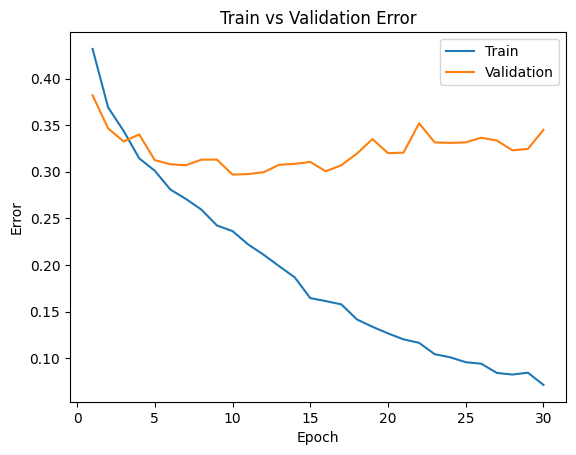

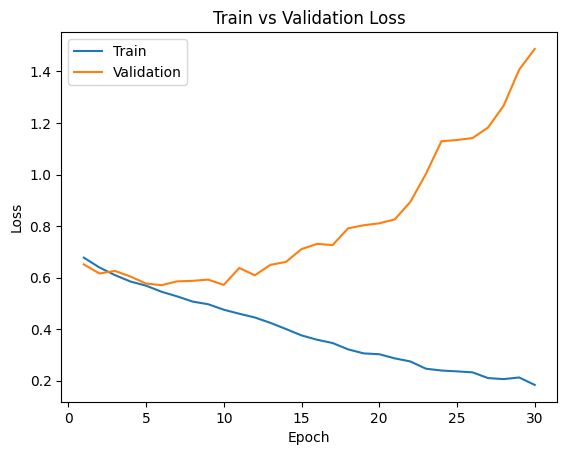

In [ ]:
large_net = LargeNet()
train_net(large_net,batch_size=16)
model_path6 = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(model_path6)

#This model took much longer to train which indicates that training the parameters
#in smaller batches slows down the efficiency of the model in terms of time.
#Similarily to the other hyperparameter that led to overfitting of the model,
#this model's error and loss graphs demonstrate a similar phenomenon.
#The training curve and the validation curve matches pretty closely before epoch5,
#which afterward the validation curve started to diverge and increase in both error and loss,
#while the training curve continued to decrease as the number of epoch increases.
#This indicated that the model may be overfitting with a much smaller batch-size
#ince they are specifically well-trained for the training data only.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

In [ ]:
#I have chosen the set of hyperparameters learning rate = 0.001 and batch size = 512
#as these hyperparameters have demonstrated good performance
#(no signs of over/underfitting, error and loss decreasing as number of empoch increases, and the training and validation curves were closely matched).
#For learning rate = 0.001, the validation error was around 0.38 and
#for batch size = 512 the validation error was around 0.37 [when used for large_net].
#Therefore, I believe it is worth trying to improve the validation accuracy
#by using a combination of both if we are only allowed to modify networkm batch_size, and learning_rate as hyperparameters.
#As of the network, I chose to use the large_net as the small_net has demonstrated that
#the data contained in the training set is underpresentative of the problem based on the analysis done on Part 2 f).
#Furthermore, using the large_net provides 2 conv2d layers which increases the model's capacities as a CNN network compared to small_net with only 1 conv2d layer,
#thus large_net would be more suitable if we are trying to make the model better performing overall.

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.487375, Train loss: 0.6930357050150633 |Validation err: 0.498, Validation loss: 0.6930510178208351
Epoch 2: Train err: 0.479375, Train loss: 0.6928794160485268 |Validation err: 0.4855, Validation loss: 0.6928166598081589
Epoch 3: Train err: 0.47075, Train loss: 0.6927735097706318 |Validation err: 0.4785, Validation loss: 0.6926646828651428
Epoch 4: Train err: 0.464625, Train loss: 0.692595237866044 |Validation err: 0.469, Validation loss: 0.6925121545791626
Epoch 5: Train err: 0.459625, Train loss: 0.6924629267305136 |Validation err: 0.455, Validation loss: 0.6922802999615669
Epoch 6: Train err: 0.455, Train loss: 0.6923208739608526 |Validation err: 0.4485, Validation loss: 0.692118726670742
Epoch 7: Train err: 0.448375, Train loss: 0.6921634785830975 |Validation err: 0.4315, Validation loss: 0.6919123157858849
Epoch 8: Train err: 0.446125, Train loss: 0.6919942144304514 |Validation err: 0

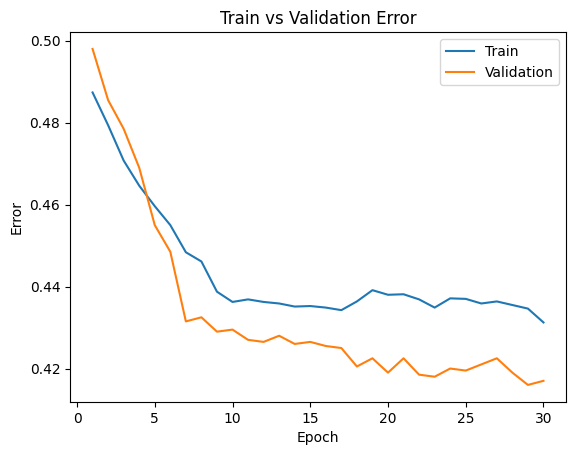

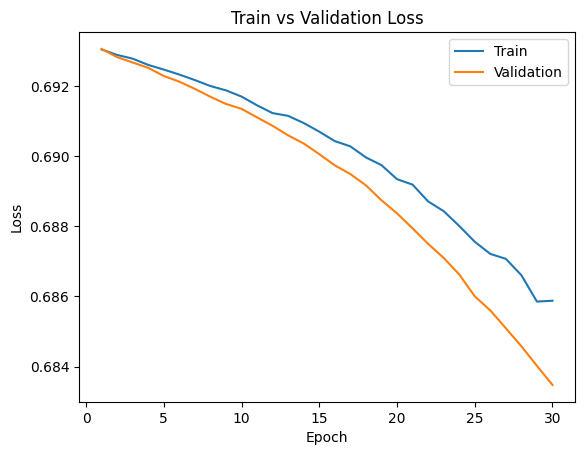

In [ ]:
large_net = LargeNet()
train_net(large_net,learning_rate=0.001, batch_size=256)
model_path_test1 = get_model_name("large", batch_size=256, learning_rate=0.001, epoch=29)
plot_training_curve(model_path_test1)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try.
Justify your choice.

In [ ]:
#From part a), it is visible that the validating curve is achiving a better accuracy
#compared to the training curve for the error graph as it has a lower error.
#Although the combination of the new parameter values did not achieve a great performance
#compared to before (around 0.38 error, now it is approximately 0.43).
#This is very rare but indicates that the model is well-generalized
#(has a holistic range of examples for the classification problem itself)
#since the validation accuracy is more important than the training accuracy.
#Since we are not taking into account the time efficiency of the training,
#512 is a very large batch of parameters to train at the same time as the typical value is around 32 or 64.
#Taking all the factors into account (both somewhat efficient yet ensures higher accuracy),
#I would like to try batch_size = 128 since it is double the amount of the default 64 (not too large of a batch),
#and we have seen based on batch_size = 512 that increasing the batch size in this problem helps with training accuracy.

#The other hyperparameter I would change is the learning rate, since the values between the default value 0.01
#and the value that has demonstrated improvement in accuracy (0.001) have not been tested.
#Since 0.001 is a very slow learning rate, it does take a long period of time to train.
#I was wondering if there is any optimal learning rate that would be smaller than the default value
#to help improve validation accuracy, but also take less time for the model to train when learning rate is 0.001.
#Therefore I chose 0.0025 which is around double of 0.001 but not too large to miss the optimal sets of weights while training.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.474875, Train loss: 0.6928134588968187 |Validation err: 0.4645, Validation loss: 0.6923997551202774
Epoch 2: Train err: 0.45225, Train loss: 0.6921217072577703 |Validation err: 0.432, Validation loss: 0.6913171671330929
Epoch 3: Train err: 0.4325, Train loss: 0.6912916558129447 |Validation err: 0.4215, Validation loss: 0.6903232112526894
Epoch 4: Train err: 0.43125, Train loss: 0.6902141769727071 |Validation err: 0.4185, Validation loss: 0.6886521093547344
Epoch 5: Train err: 0.436, Train loss: 0.6888038667421492 |Validation err: 0.4205, Validation loss: 0.6866563037037849
Epoch 6: Train err: 0.4365, Train loss: 0.6871443381385197 |Validation err: 0.421, Validation loss: 0.684324137866497
Epoch 7: Train err: 0.4315, Train loss: 0.6853143222748287 |Validation err: 0.411, Validation loss: 0.6820041723549366
Epoch 8: Train err: 0.429875, Train loss: 0.6834995273559813 |Validation err: 0.4165,

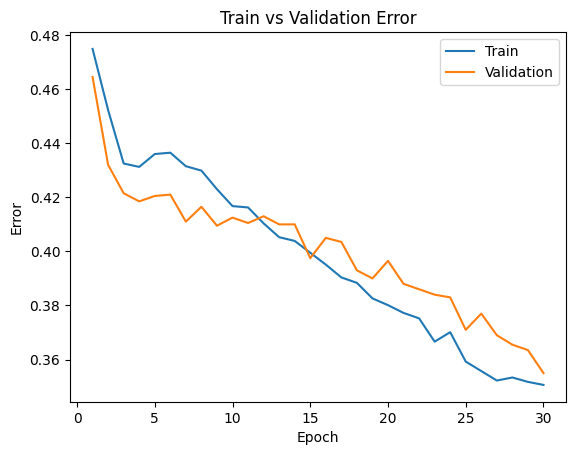

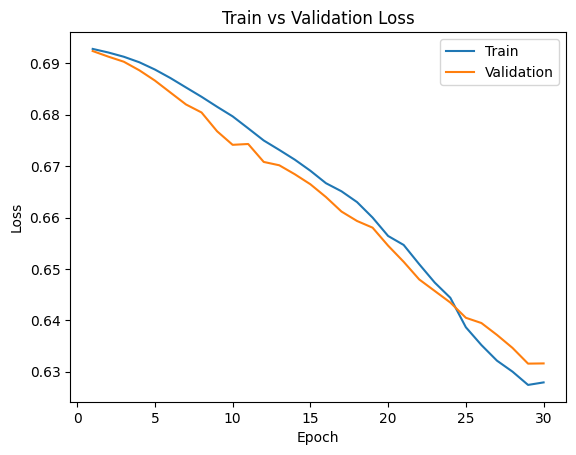

In [ ]:
large_net = LargeNet()
train_net(large_net,learning_rate=0.0025, batch_size=128)
model_path_test2 = get_model_name("large", batch_size=128, learning_rate=0.0025, epoch=29)
plot_training_curve(model_path_test2)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`,
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = LargeNet()
model_path_best = get_model_name("large", batch_size=128, learning_rate=0.0025, epoch=29)
state = torch.load(model_path_best)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

In [ ]:
#The batch size, network, and learning rate was inherited from the best model
#that was observed with the highest validation accuracy.
#Based on that model, the achieved validation error is 0.355 and the training error is 0.351.
#This was achieved with batch_size = 128, learning_rate = 0.0025, and epoch=29 with large_net as the network.
#This error is lower than all other models that was trained.
#Based on the graph that was generated from the previous section, the training and
#validation curves are also closely matched without major diverging.
#After attempting to modify the model, it was easy to over/underfit by changing the number of epoch.
#Overall, the values different from the default training values is that
#the batch size is double of the default value of 64, and the learning rate is smaller.
#This ensured that the model will not be overfitting with too small of a batch size
#yet a small learning rate at the same time.
#Therefore, I chose these parameters.

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=128)

loss_func = nn.BCEWithLogitsLoss()

test_stats = evaluate(net, test_loader, loss_func)
#Based on part 0, the evaluate function will return a tuple of (error, loss),
#therefore if classification erro we would only need the first value.
print("The test classification error for my chosen model is:", test_stats[0])

Files already downloaded and verified
Files already downloaded and verified
The test classification error for my chosen model is: 0.355


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [ ]:
val_stats = evaluate(net, val_loader, loss_func)
print("The validation classification error for my chosen model is:", val_stats[0])

#It is expected that the test error to be higher than the validation error as the testing data is unseen by the model,
#which although the validation data is not diretly used as training data, the model has seen it.
#Second, we were trying to select the model with the lowest validation error,
#which in such case these hyperparameters have shown good performance on the validation data.
#Therefore, the test error should technically be smaller than the validation error.
#However, in the case of my chosen hyperparameters, the testing data error is the same as the validation error.
#It could have been caused by the way how the data set was split into training, validation, and testing data
#since if there is similarties in the examples, then the error of the same model would have been similar too.
#It is also unknown if there is any biases in the testing data set (favoring specific class, etc),
#which may have lead to the validation data and the testing data having the same error value.

The validation classification error for my chosen model is: 0.355


### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

In [ ]:
#We only use the test data set at the very end and as little as possible as
#it is important in evaluating the model's performance using completely new and unseen data.
#If the model has already seen the data during training and validation,
#then its well performance on these data cannot make us conclude that
#it is doing good at this defined probelm overall.
#Using test data can help us to identify if there if the model is underfitting or overfitting
#on the training data and can help us in reflecting the choice of hyperparameter and how the data sets are split.

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.422625, Train loss: 0.6757829246066865 |Validation err: 0.4005, Validation loss: 0.6630493924021721
Epoch 2: Train err: 0.388625, Train loss: 0.6570770712125868 |Validation err: 0.395, Validation loss: 0.6555588282644749
Epoch 3: Train err: 0.3775, Train loss: 0.6479693159224496 |Validation err: 0.388, Validation loss: 0.652857843786478
Epoch 4: Train err: 0.375, Train loss: 0.6410365010064746 |Validation err: 0.3855, Validation loss: 0.6516415327787399
Epoch 5: Train err: 0.36525, Train loss: 0.6358712202026731 |Validation err: 0.374, Validation loss: 0.6474841870367527
Epoch 6: Train err: 0.357875, Train loss: 0.6308875292066544 |Validation err: 0.38, Validation loss: 0.6480178982019424
Epoch 7: Train err: 0.353375, Train loss: 0.6265375358717782 |Validation err: 0.38, Validation loss: 0.6454960480332375
Epoch 8:

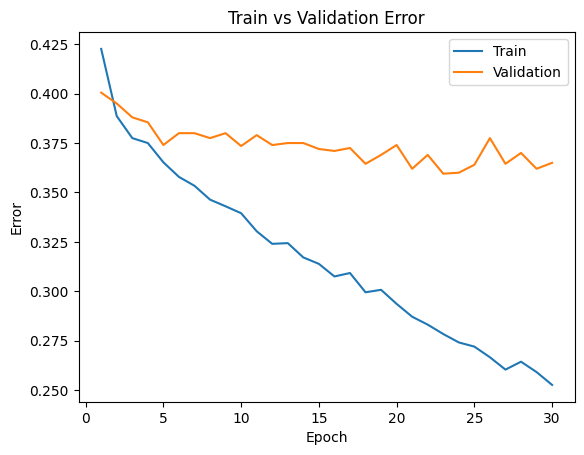

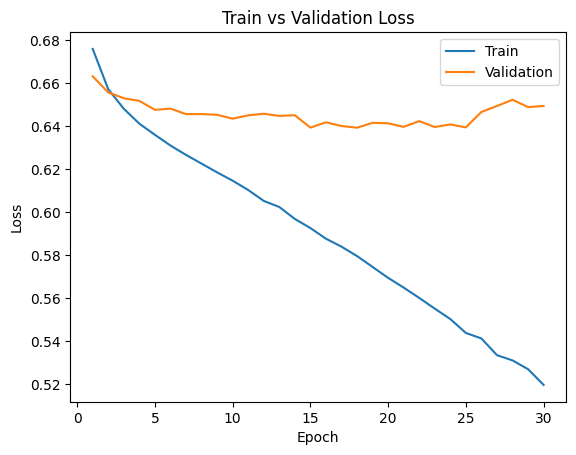

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.optim as optim

torch.manual_seed(1)

class Pigeon(nn.Module):
    def __init__(self):
        super(Pigeon, self).__init__()
        self.name = "pigeon"
        self.layer1 = nn.Linear(3*32*32, 30)
        self.layer2 = nn.Linear(30, 1)
    def forward(self, img):
        flattened = img.view(-1, 3*32*32)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        activation2 = activation2.squeeze(1)
        return activation2

pigeon = Pigeon()

train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=128)

train_net(pigeon, batch_size=128,learning_rate=0.0025,num_epochs=30)

loss_func = nn.BCEWithLogitsLoss()
val_stats = evaluate(pigeon, val_loader, loss_func)
print("The validation classification error for my chosen model is:", val_stats[0])

pigeon_model_path = get_model_name("pigeon", batch_size=128, learning_rate=0.0025, epoch=29)
plot_training_curve(pigeon_model_path)

In [ ]:
testing = nn.BCEWithLogitsLoss()

test_err, test_loss = evaluate(pigeon, test_loader, testing)
print("The testing error for the 2 layer ANN model is: ",test_err)

#Based on the returned error, the testing error for the 2-layer ANN is 0.3625 and the testing error for the 2-layer CNN network is 0.3552.
#There is a visible better peformance for the CNN network.
#Furthermore, as we could observe in the graph above for the 2-layer ANN network's validation and training curve error/loss (modified from lab 1),
#based the validation curve is visibly diverging from the training curve as the number of epoch increases, which indicates signs of overfitting on the training data.
#The reason why it is doing better on the testing data may be issues with biases in the dataset spliting or if there is higher similarities between the training and testing data.
#Overall, we can conclude that CNN networks are slightly better at classification of images compared to fully connected ANN networks based on the results.

The testing error for the 2 layer ANN model is:  0.3625
